# Graph EBM v3 — Two-Step Training Pipeline

**Objective:** Train a Graph Energy-Based Model (EBM) that learns the energy landscape of optimal binary configurations conditioned on Hierarchical Temporal Encoder (HTE) embeddings.

## Two-Step Training
- **Step A (Gold Pre-training):** Contrastive Divergence on gold scenarios using `NormalizedTemporalLangevinSampler`
- **Step B (Silver Fine-tuning):** CD + Preference loss on silver scenarios using Feasibility Decoder v4 + `LPWorkerTwoStage`

## Architecture
- **Model:** `TrajectoryZonalEBM` — GRU-based temporal energy model with zone masking
- **Sampler:** `NormalizedTemporalLangevinSampler` — Langevin dynamics in logit space with temperature annealing
- **Decoder:** `HierarchicalFeasibilityDecoder` v4 — Cost-aware merit order projection
- **LP Oracle:** `LPWorkerTwoStage` — Two-stage LP solver for preference learning

## Requirements
- **Runtime:** A100 GPU, High RAM
- **Data:** HTE embeddings + scenario reports in Google Drive

## 1. Environment Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
BASE_DIR = '/content/drive/MyDrive/benchmark'
assert os.path.isdir(BASE_DIR), f'Base directory not found: {BASE_DIR}'
print(f'Base directory: {BASE_DIR}')

Mounted at /content/drive
Base directory: /content/drive/MyDrive/benchmark


In [2]:
# Install dependencies
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

!pip install pyomo highspy thrml

import torch
print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB')

Found existing installation: torch 2.9.0+cu128
Uninstalling torch-2.9.0+cu128:
  Successfully uninstalled torch-2.9.0+cu128
Found existing installation: torchvision 0.24.0+cu128
Uninstalling torchvision-0.24.0+cu128:
  Successfully uninstalled torchvision-0.24.0+cu128
Found existing installation: torchaudio 2.9.0+cu128
Uninstalling torchaudio-2.9.0+cu128:
  Successfully uninstalled torchaudio-2.9.0+cu128
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 126.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Add src to path
import torch
import sys
src_path = os.path.join(BASE_DIR, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
    sys.path.insert(0, BASE_DIR)

# Verify imports
from src.ebm.config_v3 import EBMv3Config
from src.ebm.model_v3 import TrajectoryZonalEBM
from src.ebm.sampler_v3 import NormalizedTemporalLangevinSampler
from src.ebm.dataset_v3 import (
    ScenarioReportDataset, temporal_collate_fn, build_dataloaders,
    load_classification_index,
)
from src.ebm.loss_v3 import ContrastiveDivergenceLoss, CombinedLoss
from src.ebm.feasibility import (
    ScenarioPhysics, FeasiblePlan, HierarchicalFeasibilityDecoder,
    load_physics_from_scenario,
)
from src.ebm.train_v3 import (
    run_gold_pretraining, run_silver_finetuning, run_full_pipeline,
)

print('All v3 modules imported successfully')

All v3 modules imported successfully


## 2. Configuration

In [3]:
config = EBMv3Config(
    base_dir=BASE_DIR,
    # Data dimensions
    n_timesteps=24,
    n_features=7,
    embed_dim=128,
    # Model
    hidden_dim=128,
    gru_layers=2,
    bidirectional=True,
    dropout=0.1,
    use_peak_term=True,
    peak_tau=0.5,
    peak_weight=0.3,
    energy_max=50.0,              # tanh-bound: E ∈ [-50, 50]
    # Sampler
    langevin_steps=100,           # inference (more refined)
    langevin_train_steps_start=10,  # curriculum: weak adversary at epoch 0
    langevin_train_steps_end=50,    # curriculum: full-strength by mid-training
    langevin_step_size=0.05,
    langevin_noise=0.50,
    langevin_temp_max=1.0,
    langevin_temp_min=0.1,
    langevin_init_mode='soft',
    langevin_prior_p=0.025,
    langevin_prior_strength=0.0,
    langevin_normalize_grad=True,
    # Negative sampling: 100% Langevin (no corruption, no random)
    langevin_ratio_start=1.0,
    langevin_ratio_end=1.0,
    random_neg_sparsity=0.025,    # (unused in training — kept for validation)
    corruption_flip_rate=0.05,    # (unused — kept for compatibility)
    # Training
    batch_size=32,
    learning_rate=2e-5,
    use_amp=True,
    seed=42,
    # Step A
    gold_epochs=50,
    gold_lr=2e-5,
    gold_patience=10,
    # Step B
    silver_epochs=30,
    silver_lr=1e-5,
    silver_patience=8,
    silver_min_delta=0.01,
    silver_langevin_start=20,     # curriculum: gentle start (gold peaked at ~32 steps)
    silver_langevin_end=35,       # curriculum: don't exceed gold's peak
    silver_lp_eval_every=5,
    silver_lp_scenarios_per_batch=4,
    silver_preference_margin=0.1,
    silver_lambda_cd=1.0,
    silver_lambda_pref=0.5,
)

print(f'Reports dir:    {config.reports_dir}')
print(f'Embeddings dir: {config.embeddings_dir}')
print(f'Output dir:     {config.output_dir}')
print(f'Device:         {config.device}')
print(f'Model: energy_max={config.energy_max}')
print(f'Sampler: train={config.langevin_train_steps_start}\u2192{config.langevin_train_steps_end} steps (gold curriculum), '
      f'infer={config.langevin_steps} steps, '
      f'noise={config.langevin_noise}, temp=[{config.langevin_temp_min}, {config.langevin_temp_max}]')
print(f'Neg sampling: 100% Langevin (no corruption, no random)')
print(f'Gold LR: {config.gold_lr}, CD clamp=[-10,10]')
print(f'Silver LR: {config.silver_lr}, {config.silver_langevin_start}\u2192{config.silver_langevin_end} Langevin steps (curriculum)')
print(f'Silver early stopping: ValGap_L, min_delta={config.silver_min_delta}, patience={config.silver_patience}')
print(f'LP worker: cached, eval every {config.silver_lp_eval_every} batches')

Reports dir:    /content/drive/MyDrive/benchmark/outputs/scenarios_v3/reports
Embeddings dir: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3
Output dir:     /content/drive/MyDrive/benchmark/outputs/ebm_models/ebm_v3
Device:         cuda
Model: energy_max=50.0
Sampler: train=10→50 steps (gold curriculum), infer=100 steps, noise=0.5, temp=[0.1, 1.0]
Neg sampling: 100% Langevin (no corruption, no random)
Gold LR: 2e-05, CD clamp=[-10,10]
Silver LR: 1e-05, 20→35 Langevin steps (curriculum)
Silver early stopping: ValGap_L, min_delta=0.01, patience=8
LP worker: cached, eval every 5 batches


## 3. Data Exploration

In [10]:
# Load classification index
index = load_classification_index(config.classification_index_path)
print(f"Classification summary: {index['summary']}")
print(f"Gold scenarios: {len(index['gold'])}")
print(f"Silver scenarios: {len(index['silver'])}")

# Check embeddings
if os.path.isdir(config.embeddings_dir):
    emb_files = os.listdir(config.embeddings_dir)
    print(f"\nEmbedding files: {len(emb_files)}")
    if emb_files:
        print(f"  Sample: {emb_files[:5]}")
else:
    print(f"\nEmbeddings directory not found: {config.embeddings_dir}")
    print("Please generate HTE embeddings first using HTE_v3_Colab.ipynb")

Classification summary: {'gold_count': 4388, 'silver_count': 612, 'bronze_count': 0, 'error_count': 0}
Gold scenarios: 4388
Silver scenarios: 612

Embedding files: 5001
  Sample: ['outputs\\scenarios_v3\\scenario_04002.npz', 'outputs\\scenarios_v3\\scenario_04003.npz', 'outputs\\scenarios_v3\\scenario_04004.npz', 'outputs\\scenarios_v3\\scenario_04005.npz', 'outputs\\scenarios_v3\\scenario_04006.npz']


In [11]:
# Test loading a single scenario
import json
sample_file = index['gold'][0]
sample_path = os.path.join(config.reports_dir, sample_file)

with open(sample_path, 'r') as f:
    sample_report = json.load(f)

print(f"Sample report: {sample_file}")
print(f"  MILP objective: {sample_report['mip']['objective']:.2f}")
print(f"  MILP status: {sample_report['mip']['termination']}")
print(f"  LP objective: {sample_report['lp']['objective']:.2f}")

# Test binary extraction
from src.ebm.dataset_v3 import _extract_binaries_from_report
u_test = _extract_binaries_from_report(sample_report)
if u_test is not None:
    print(f"\n  Binary tensor shape: {u_test.shape} (Z, T, F)")
    print(f"  Zones: {u_test.shape[0]}, Timesteps: {u_test.shape[1]}, Features: {u_test.shape[2]}")
    print(f"  Mean activation: {u_test.mean():.4f}")
    feat_names = ['batt_ch', 'batt_dis', 'pump_ch', 'pump_dis', 'dr', 'thermal_su', 'thermal']
    for i, name in enumerate(feat_names):
        print(f"    {name}: {u_test[:, :, i].mean():.4f}")
else:
    print("  Could not extract binaries from report")

Sample report: scenario_00001.json
  MILP objective: -8618708.93
  MILP status: optimal
  LP objective: -8641140.08

  Binary tensor shape: torch.Size([123, 24, 7]) (Z, T, F)
  Zones: 123, Timesteps: 24, Features: 7
  Mean activation: 0.0162
    batt_ch: 0.0291
    batt_dis: 0.0440
    pump_ch: 0.0064
    pump_dis: 0.0095
    dr: 0.0014
    thermal_su: 0.0017
    thermal: 0.0213


## 4. Build Gold DataLoaders

In [12]:
train_loader, val_loader, gold_dataset = build_dataloaders(
    reports_dir=config.reports_dir,
    embeddings_dir=config.embeddings_dir,
    classification_index_path=config.classification_index_path,
    tier='gold',
    n_timesteps=config.n_timesteps,
    embed_dim=config.embed_dim,
    batch_size=config.batch_size,
    val_split=config.val_split,
    seed=config.seed,
)

# Test batch
test_batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  u_zt:      {test_batch['u_zt'].shape}  (B, Z_max, T, F)")
print(f"  h_zt:      {test_batch['h_zt'].shape}  (B, Z_max, T, D)")
print(f"  zone_mask: {test_batch['zone_mask'].shape}  (B, Z_max)")
print(f"  n_zones:   {test_batch['n_zones'][:5]}")
print(f"  objectives: {test_batch['objectives'][:5]}")

Building gold dataset: 4388 scenarios in index
  Found 5000 embedding files (sample: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3/outputs\scenarios_v3\scenario_04002.npz)
  Valid scenarios with reports + embeddings: 4388
  Train: 3950 samples, 123 batches
  Val:   438 samples, 14 batches

Batch shapes:
  u_zt:      torch.Size([32, 119, 24, 7])  (B, Z_max, T, F)
  h_zt:      torch.Size([32, 119, 24, 128])  (B, Z_max, T, D)
  zone_mask: torch.Size([32, 119])  (B, Z_max)
  n_zones:   tensor([ 52,   5,  90,  11, 119])
  objectives: tensor([-1.0349e+08, -4.0881e+07, -2.3624e+07, -4.5516e+07, -4.9659e+06])


## 5. Initialize Model & Sampler

In [7]:
# Get dimensions from test batch
B, Z_max, T, F = test_batch['u_zt'].shape
D = test_batch['h_zt'].shape[-1]
print(f'Dimensions: B={B}, Z_max={Z_max}, T={T}, F={F}, D={D}')

# Initialize model
model = TrajectoryZonalEBM(
    embed_dim=D,
    n_features=F,
    hidden_dim=config.hidden_dim,
    gru_layers=config.gru_layers,
    bidirectional=config.bidirectional,
    dropout=config.dropout,
    use_peak_term=config.use_peak_term,
    peak_tau=config.peak_tau,
    peak_weight=config.peak_weight,
).to(config.device)

n_params = sum(p.numel() for p in model.parameters())
print(f'\nModel: TrajectoryZonalEBM')
print(f'  Parameters: {n_params:,}')
print(f'  Device: {config.device}')

# Test forward pass
print('\nTesting forward pass...')
with torch.no_grad():
    test_energy = model(
        test_batch['u_zt'].to(config.device),
        test_batch['h_zt'].to(config.device),
        test_batch['zone_mask'].to(config.device),
    )
print(f'  Output shape: {test_energy.shape}')
print(f'  Energy range: [{test_energy.min():.4f}, {test_energy.max():.4f}]')
assert not torch.isnan(test_energy).any(), 'NaN in energy!'
print('  Forward pass OK')

Dimensions: B=32, Z_max=126, T=24, F=7, D=128

Model: TrajectoryZonalEBM
  Parameters: 553,729
  Device: cuda

Testing forward pass...
  Output shape: torch.Size([32])
  Energy range: [0.7297, 0.7567]
  Forward pass OK


In [14]:
# Initialize sampler
sampler = NormalizedTemporalLangevinSampler(
    model=model,
    n_features=F,
    num_steps=config.langevin_steps,
    step_size=config.langevin_step_size,
    noise_scale=config.langevin_noise,
    temp_max=config.langevin_temp_max,
    temp_min=config.langevin_temp_min,
    init_mode=config.langevin_init_mode,
    prior_p=config.langevin_prior_p,
    prior_strength=config.langevin_prior_strength,
    normalize_grad=config.langevin_normalize_grad,
    device=config.device,
    mode='train',
)

# Test sampling
print('\nTesting Langevin sampling (10 steps)...')
sampler_test = NormalizedTemporalLangevinSampler(
    model=model, n_features=F, num_steps=10,
    step_size=0.02, noise_scale=0.3,
    device=config.device, mode='train',
)
h_test = test_batch['h_zt'][:2].to(config.device)
mask_test = test_batch['zone_mask'][:2].to(config.device)
u_sampled = sampler_test.sample(h_test, mask_test)
print(f'  Sampled u shape: {u_sampled.shape}')
print(f'  Mean activation: {u_sampled.mean():.4f}')
assert not torch.isnan(u_sampled).any(), 'NaN in sampled u!'
print('  Sampling OK')

NameError: name 'F' is not defined

## 6. Step A — Gold Pre-Training

Train the EBM on gold scenarios using Contrastive Divergence.
The model learns to assign low energy to real MILP solutions and high energy to random/sampled configurations.

In [9]:
# Run gold pre-training
model, gold_history = run_gold_pretraining(config)

STEP A: GOLD PRE-TRAINING
Building gold dataset: 4388 scenarios in index
  Found 5000 embedding files (sample: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3/outputs\scenarios_v3\scenario_04002.npz)
  Valid scenarios with reports + embeddings: 4388
  Train: 3950 samples, 123 batches
  Val:   438 samples, 14 batches
Model parameters: 553,729
Training sampler: 10→50 Langevin steps (curriculum), step_size=0.05, noise=0.5
  [Epoch 0] Batch 10/123 | CD=0.0037 | Gap=-0.0067 | E+=-0.080 E-=-0.084 flip=0.021 [L]
  [Epoch 0] Batch 20/123 | CD=-0.0025 | Gap=-0.0052 | E+=-0.107 E-=-0.104 flip=0.021 [L]
  [Epoch 0] Batch 30/123 | CD=0.0045 | Gap=-0.0039 | E+=-0.105 E-=-0.109 flip=0.019 [L]
  [Epoch 0] Batch 40/123 | CD=0.0003 | Gap=-0.0028 | E+=-0.083 E-=-0.083 flip=0.017 [L]
  [Epoch 0] Batch 50/123 | CD=0.0012 | Gap=-0.0023 | E+=-0.055 E-=-0.056 flip=0.017 [L]
  [Epoch 0] Batch 60/123 | CD=-0.0012 | Gap=-0.0019 | E+=-0.015 E-=-0.013 flip=0.018 [L]
  [Epo

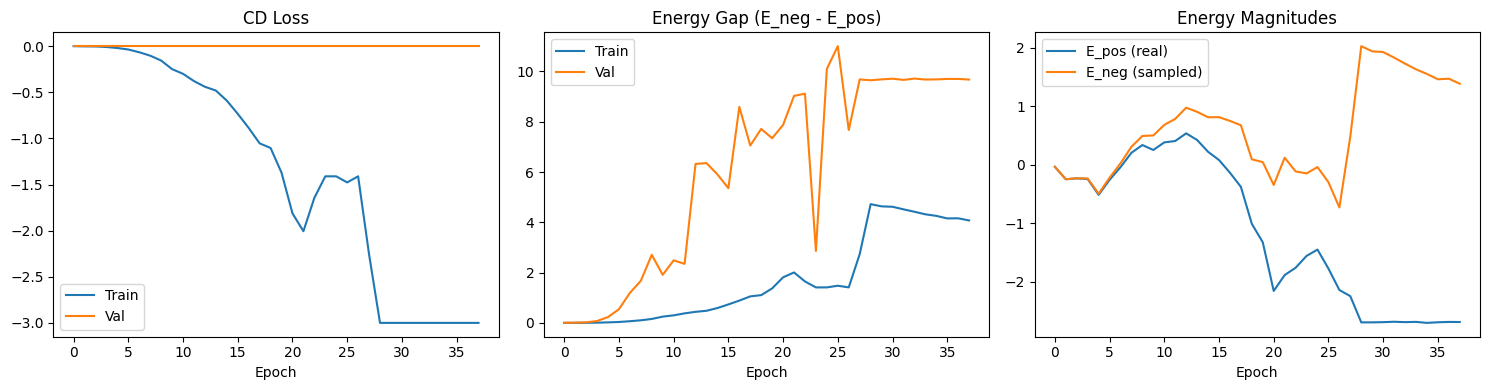

Gold training curves saved.


In [10]:
# Plot gold training curves
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# CD loss
train_cd = [m.get('cd_loss', 0) for m in gold_history['train']]
val_cd = [m.get('cd_loss', 0) for m in gold_history['val']]
axes[0].plot(train_cd, label='Train')
axes[0].plot(val_cd, label='Val')
axes[0].set_title('CD Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# Energy gap
train_gap = [m.get('E_gap', 0) for m in gold_history['train']]
val_gap = [m.get('E_gap', 0) for m in gold_history['val']]
axes[1].plot(train_gap, label='Train')
axes[1].plot(val_gap, label='Val')
axes[1].set_title('Energy Gap (E_neg - E_pos)')
axes[1].set_xlabel('Epoch')
axes[1].legend()

# Energy magnitudes
train_epos = [m.get('E_pos_mean', 0) for m in gold_history['train']]
train_eneg = [m.get('E_neg_mean', 0) for m in gold_history['train']]
axes[2].plot(train_epos, label='E_pos (real)')
axes[2].plot(train_eneg, label='E_neg (sampled)')
axes[2].set_title('Energy Magnitudes')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'gold_training_curves.png'), dpi=150)
plt.show()
print('Gold training curves saved.')

## 7. MCMC Chain Diagnostics (Post Gold)

Verify that the Langevin sampler converges after gold pre-training.

Running MCMC chain diagnostics...
Batch: 32 samples, 129 zones, 24 timesteps, 7 features
  Chain 1: Final E = 2.5325
  Chain 2: Final E = 2.4659
  Chain 3: Final E = 2.5892
  Chain 4: Final E = 2.5924
  Chain 5: Final E = 2.4602


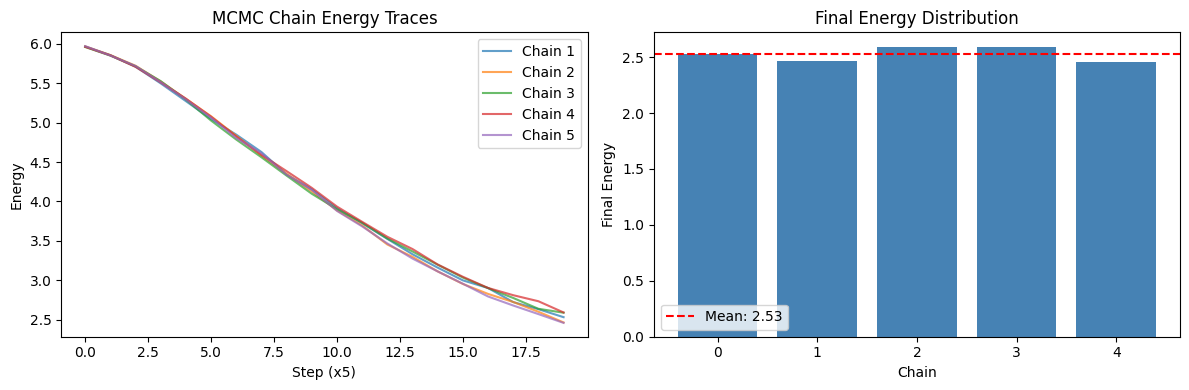


Chain Convergence Summary:
  Mean final energy: 2.5281
  Std final energy: 0.0572
  Ground truth energy: -3.1514
  Gap (chains - real): 5.6795


In [11]:
# MCMC chain diagnostics
import torch
import numpy as np
import matplotlib.pyplot as plt

print('Running MCMC chain diagnostics...')

val_batch = next(iter(val_loader))
u_real = val_batch['u_zt'].to(config.device)
h_zt = val_batch['h_zt'].to(config.device)
zone_mask = val_batch['zone_mask'].to(config.device)

B, Z, T, F = u_real.shape
print(f'Batch: {B} samples, {Z} zones, {T} timesteps, {F} features')

n_chains = 5
chain_energies = []

model.train()
for chain_idx in range(n_chains):
    z = torch.randn(B, Z, T, F, device=config.device) * 0.1 + sampler.prior_logit
    z = z.requires_grad_(True)
    chain_energy = []

    for step in range(100):
        u = torch.sigmoid(z)
        mask = zone_mask.view(B, Z, 1, 1).float()
        u_masked = u * mask

        energy = model(u_masked, h_zt, zone_mask).sum()
        grad_z = torch.autograd.grad(energy, z)[0]

        g_std = grad_z.std()
        if g_std > 1e-9:
            grad_z = grad_z / g_std

        noise = torch.randn_like(z) * 0.1
        z = z - 0.02 * grad_z + noise
        z = z * mask
        z = z.detach().requires_grad_(True)

        if step % 5 == 0:
            with torch.no_grad():
                e = model(torch.sigmoid(z) * mask, h_zt, zone_mask).mean().item()
            chain_energy.append(e)

    chain_energies.append(chain_energy)
    print(f'  Chain {chain_idx+1}: Final E = {chain_energy[-1]:.4f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, energies in enumerate(chain_energies):
    axes[0].plot(energies, label=f'Chain {i+1}', alpha=0.7)
axes[0].set_xlabel('Step (x5)')
axes[0].set_ylabel('Energy')
axes[0].set_title('MCMC Chain Energy Traces')
axes[0].legend()

final_energies = [e[-1] for e in chain_energies]
axes[1].bar(range(n_chains), final_energies, color='steelblue')
axes[1].axhline(y=np.mean(final_energies), color='red', linestyle='--',
                label=f'Mean: {np.mean(final_energies):.2f}')
axes[1].set_xlabel('Chain')
axes[1].set_ylabel('Final Energy')
axes[1].set_title('Final Energy Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'mcmc_diagnostics.png'), dpi=150)
plt.show()

with torch.no_grad():
    E_real = model(u_real, h_zt, zone_mask).mean().item()

print(f'\nChain Convergence Summary:')
print(f'  Mean final energy: {np.mean(final_energies):.4f}')
print(f'  Std final energy: {np.std(final_energies):.4f}')
print(f'  Ground truth energy: {E_real:.4f}')
print(f'  Gap (chains - real): {np.mean(final_energies) - E_real:.4f}')

## 8. Step B — Silver Fine-Tuning

Fine-tune the gold-pretrained model on silver scenarios using:
- Contrastive Divergence loss (standard)
- Preference loss from LP oracle evaluation via `HierarchicalFeasibilityDecoder` v4 + `LPWorkerTwoStage`

In [4]:
# (Optional) Reload gold model from checkpoint — use this to skip gold training
# Only needed if re-running silver without re-running gold first
import os, torch

gold_ckpt_path = os.path.join(config.output_dir, 'gold_best.pt')
assert os.path.exists(gold_ckpt_path), f'Gold checkpoint not found: {gold_ckpt_path}'

# Initialize fresh model
model = TrajectoryZonalEBM(
    embed_dim=config.embed_dim,
    n_features=config.n_features,
    hidden_dim=config.hidden_dim,
    gru_layers=config.gru_layers,
    bidirectional=config.bidirectional,
    dropout=config.dropout,
    use_peak_term=config.use_peak_term,
    peak_tau=config.peak_tau,
    peak_weight=config.peak_weight,
    energy_max=config.energy_max,
).to(config.device)

# Load gold weights
ckpt = torch.load(gold_ckpt_path, map_location=config.device, weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])
print(f'Loaded gold checkpoint: {gold_ckpt_path}')
print(f'  Epoch: {ckpt.get("epoch", "?")}')
print(f'  Val gap: {ckpt.get("val_gap", "?")}')

Loaded gold checkpoint: /content/drive/MyDrive/benchmark/outputs/ebm_models/ebm_v3/gold_best.pt
  Epoch: 27
  Val gap: 9.682771716799055


In [5]:
# Run silver fine-tuning (uses pre-trained gold model)
model, silver_history = run_silver_finetuning(model, config)

STEP B: SILVER FINE-TUNING
Building silver dataset: 612 scenarios in index
  Found 5000 embedding files (sample: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal_v3/embeddings_v3/outputs\scenarios_v3\scenario_04002.npz)
  Valid scenarios with reports + embeddings: 612
  Train: 551 samples, 17 batches
  Val:   61 samples, 2 batches
Silver sampler: 20→35 Langevin steps (curriculum), step_size=0.05, noise=0.5
✓ LPWorkerTwoStage initialized
  Solver: appsi_highs
  Slack tolerance: 1.0 MWh (dt=1.0h)
  Deviation penalty (λ): 10000.0
  Flip budgets: K=20→100, K=100→1000, full_soft→None
  Time limits: TL1=20.0s, TL2=15.0s, TL3=120.0s, TL4=900.0s
LP worker cached for silver fine-tuning
    LP pair scenario_04088: cost_best=84293803 cost_worst=142316278 E_better=5.4363 E_worse=2.0311
    LP pair scenario_03342: cost_best=49037424 cost_worst=124901286 E_better=5.4360 E_worse=1.7396
    LP pair scenario_01415: cost_best=89505814 cost_worst=192495845 E_better=5.4299 E_worse=0

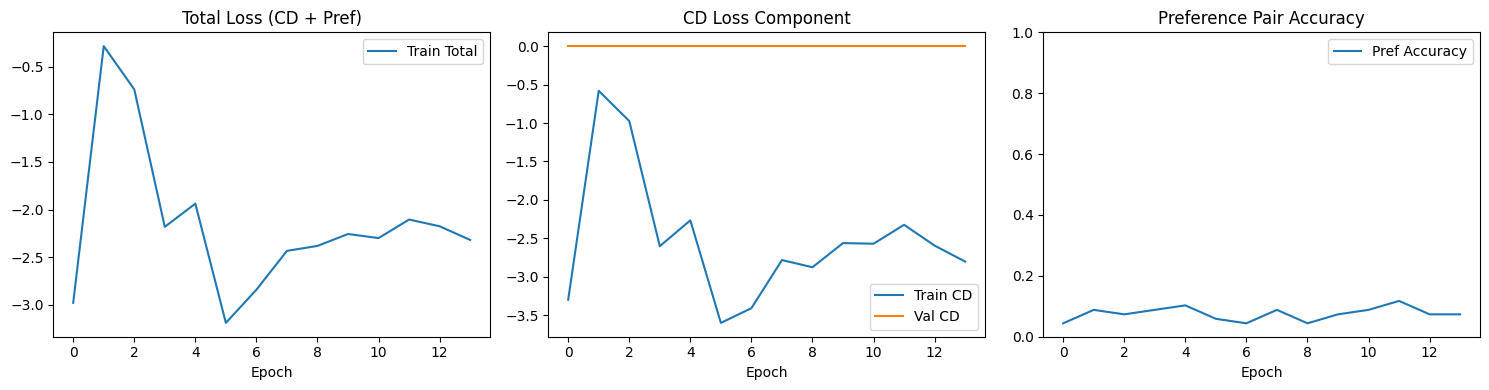

Silver training curves saved.


In [8]:
import matplotlib.pyplot as plt

# Plot silver training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
train_total = [m.get('loss_total', 0) for m in silver_history['train']]
axes[0].plot(train_total, label='Train Total')
axes[0].set_title('Total Loss (CD + Pref)')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# CD component
train_cd = [m.get('cd/cd_loss', 0) for m in silver_history['train']]
val_cd = [m.get('cd_loss', 0) for m in silver_history['val']]
axes[1].plot(train_cd, label='Train CD')
axes[1].plot(val_cd, label='Val CD')
axes[1].set_title('CD Loss Component')
axes[1].set_xlabel('Epoch')
axes[1].legend()

# Preference accuracy
train_pref_acc = [m.get('pref/pref_accuracy', 0) for m in silver_history['train']]
if any(v > 0 for v in train_pref_acc):
    axes[2].plot(train_pref_acc, label='Pref Accuracy')
    axes[2].set_title('Preference Pair Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylim(0, 1)
    axes[2].legend()
else:
    val_gap = [m.get('E_gap', 0) for m in silver_history['val']]
    axes[2].plot(val_gap, label='Val Gap')
    axes[2].set_title('Val Energy Gap')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, 'silver_training_curves.png'), dpi=150)
plt.show()
print('Silver training curves saved.')

## 9. Multi-Candidate Generation & Evaluation

Generate K candidates per scenario with the Langevin sampler, evaluate energy, and optionally run through the feasibility decoder.

In [13]:
K_CANDIDATES = 10
N_SCENARIOS = 20

print('=' * 80)
print('MULTI-CANDIDATE GENERATION')
print('=' * 80)
print(f'K candidates: {K_CANDIDATES}')
print(f'Scenarios: {N_SCENARIOS}')

val_batch = next(iter(val_loader))
h_zt = val_batch['h_zt'].to(config.device)
zone_mask = val_batch['zone_mask'].to(config.device)
u_real = val_batch['u_zt'].to(config.device)
scenario_ids = val_batch['scenario_ids']

B = min(N_SCENARIOS, h_zt.shape[0])
model.train()  # Required for GRU backward

all_candidates = []
all_energies = []

for i in range(B):
    h_i = h_zt[i:i+1]
    mask_i = zone_mask[i:i+1]

    candidates_i = []
    energies_i = []

    for k in range(K_CANDIDATES):
        u_sample = sampler.sample(h_i, mask_i)
        with torch.no_grad():
            E = model(u_sample, h_i, mask_i).item()
        candidates_i.append(u_sample[0].cpu())
        energies_i.append(E)

    all_candidates.append(torch.stack(candidates_i))
    all_energies.append(torch.tensor(energies_i))

    if (i + 1) % 5 == 0:
        print(f'  Generated candidates for {i+1}/{B} scenarios')

# Select best candidates
best_candidates = []
best_energies = []
for i in range(B):
    best_idx = all_energies[i].argmin()
    best_candidates.append(all_candidates[i][best_idx])
    best_energies.append(all_energies[i][best_idx].item())

print(f'\nBest candidate energies:')
print(f'  Mean: {np.mean(best_energies):.4f}')
print(f'  Std:  {np.std(best_energies):.4f}')

# Compare with ground truth
with torch.no_grad():
    gt_energies = []
    for i in range(B):
        E_gt = model(
            u_real[i:i+1], h_zt[i:i+1], zone_mask[i:i+1]
        ).item()
        gt_energies.append(E_gt)

print(f'\nGround truth energies:')
print(f'  Mean: {np.mean(gt_energies):.4f}')
print(f'  Gap (best - GT): {np.mean(best_energies) - np.mean(gt_energies):.4f}')

MULTI-CANDIDATE GENERATION
K candidates: 10
Scenarios: 20


NameError: name 'sampler' is not defined

## 10. Feasibility Decoder + LP Evaluation (Optional)

Apply the HierarchicalFeasibilityDecoder v4 to the best candidates and evaluate with the LP solver.

In [ ]:
# Apply feasibility decoder to best candidates
N_DECODE = min(5, len(best_candidates))

print('=' * 80)
print('FEASIBILITY DECODER APPLICATION')
print('=' * 80)

for i in range(N_DECODE):
    sc_id = scenario_ids[i]
    n_zones_i = int(zone_mask[i].sum().item())
    u_best = best_candidates[i][:n_zones_i]  # Trim padded zones

    print(f'\nScenario {sc_id} ({n_zones_i} zones):')
    print(f'  u_best shape: {u_best.shape}')

    try:
        physics = load_physics_from_scenario(
            sc_id, config.scenarios_dir, config.n_timesteps,
        )
        decoder = HierarchicalFeasibilityDecoder(physics)
        plan = decoder.decode(u_best)
        u_feasible = plan.to_tensor()

        print(f'  Decoded plan shape: {u_feasible.shape}')
        print(f'  Thermal dispatch: {plan.thermal_dispatch.sum():.0f} MWh')
        print(f'  Nuclear dispatch: {plan.nuclear_dispatch.sum():.0f} MWh')
        print(f'  Unserved energy: {plan.unserved_energy.sum():.1f} MWh')
        print(f'  Curtailment: {plan.curtailment.sum():.1f} MWh')
    except Exception as e:
        print(f'  Decoder failed: {e}')

print('\nDone.')

## 11. Save Final Model & Summary

In [15]:
# Save final model with full config
final_path = os.path.join(config.output_dir, 'ebm_v3_final.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'embed_dim': config.embed_dim,
        'n_features': config.n_features,
        'hidden_dim': config.hidden_dim,
        'gru_layers': config.gru_layers,
        'bidirectional': config.bidirectional,
        'dropout': config.dropout,
        'use_peak_term': config.use_peak_term,
        'peak_tau': config.peak_tau,
        'peak_weight': config.peak_weight,
        'energy_max': config.energy_max,
    },
    'sampler_config': {
        'langevin_steps': config.langevin_steps,
        'langevin_step_size': config.langevin_step_size,
        'langevin_noise': config.langevin_noise,
        'langevin_temp_max': config.langevin_temp_max,
        'langevin_temp_min': config.langevin_temp_min,
        'langevin_prior_p': config.langevin_prior_p,
    },
}, final_path)

print(f'Final model saved to: {final_path}')

# List all outputs
print(f'\nOutput directory: {config.output_dir}')
for f in sorted(os.listdir(config.output_dir)):
    fpath = os.path.join(config.output_dir, f)
    size_mb = os.path.getsize(fpath) / 1e6
    print(f'  {f:40s} {size_mb:.2f} MB')

print('\nTraining complete!')

Final model saved to: /content/drive/MyDrive/benchmark/outputs/ebm_models/ebm_v3/ebm_v3_final.pt

Output directory: /content/drive/MyDrive/benchmark/outputs/ebm_models/ebm_v3
  ebm_v3_final.pt                          2.22 MB
  gold_best.pt                             6.68 MB
  gold_epoch_10.pt                         6.68 MB
  gold_epoch_15.pt                         6.68 MB
  gold_epoch_20.pt                         6.68 MB
  gold_epoch_25.pt                         6.68 MB
  gold_epoch_30.pt                         6.68 MB
  gold_epoch_35.pt                         6.68 MB
  gold_epoch_40.pt                         6.68 MB
  gold_epoch_45.pt                         6.68 MB
  gold_epoch_5.pt                          6.68 MB
  gold_history.json                        0.03 MB
  gold_training_curves.png                 0.11 MB
  mcmc_diagnostics.png                     0.09 MB
  silver_best.pt                           6.68 MB
  silver_epoch_10.pt                       6.68 MB
  silver_